# Sentiment analysis with RNN

In [1]:
import numpy as np
import scipy.sparse
import json
import zipfile as zip

import spacy
from keras.preprocessing import text, sequence
from gensim import corpora
from gensim.models import tfidfmodel
from gensim.matutils import corpus2csc
from gensim.corpora.dictionary import Dictionary

import matplotlib.pyplot as plt
import seaborn as sns

import sys
from collections import Counter, OrderedDict
from os.path import expanduser

import keras.backend as K
from keras.utils import to_categorical
from keras import models, optimizers, regularizers
from keras.layers import Dropout, Dense, Activation, Flatten, LSTM, \
Conv1D, MaxPooling1D, GRU, Embedding, CuDNNLSTM, Bidirectional

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


# Importing

Data is preprocessed as a list of lists, reviews are parsed and stop words and punctuation are removed.

In [2]:
re_run = False

if re_run:
    # processed from gensim_walkthrough notebook
    with open('../../data/processed/processed.txt', 'r') as f:
        restaurants = tuple(json.loads(line) for line in f)

    # different text cleaning for reviews
    with open('../../data/processed/reviews_cleaned.txt', 'r') as f:
        reviews = tuple(json.loads(line) for line in f)

## Doing the same process with gensim

Skipping a step by not creating two dictionaries for train and test, they get recombined anyway for an update of new data though.

In [3]:
%%time

if re_run:
    
    # create dictionary
    dict_yelp = corpora.Dictionary(reviews)
    # tune corpus to get a smaller dictionary and therefore a smaller doc_term matrix, 
    # embeddings will still work but bow will not fit into 8gb gpu otherwise
    dict_yelp.filter_extremes(no_below=10, keep_n=13000)
    dict_yelp.save('../../data/processed/dictionary')

else:
    
    dict_yelp = corpora.Dictionary.load('../../data/processed/dictionary')

print(len(dict_yelp))

13000
CPU times: user 5.1 ms, sys: 97 µs, total: 5.2 ms
Wall time: 4.9 ms


In [4]:
if re_run:
    # most common words
    top_ids = sorted(dict_yelp.dfs.items(), key=lambda x: x[1], reverse=True)[0:30]
    [(dict_yelp[item[0]], item[1]) for item in top_ids]

In [5]:
def text_sequencer(dictionary, text, max_len=200):
    
    processed = []
    # in case the word is not in the dictionary because it was filtered out use this number to represent an out of set id 
    dict_final = len(dictionary.keys()) + 1
    
    for i, word in enumerate(text):
        if i > max_len - 1:
            break
        if word in dictionary.token2id.keys():
    # remember the ids have an offset of 1 for this because 0 represents a padded value        
            processed.append(dictionary.token2id[word] + 1) 
        else:
            processed.append(dict_final)
    
    return processed      

In [6]:
%%time

if re_run:
    
    corpus = tuple(text_sequencer(dict_yelp, review) for review in reviews)
    corpus = sequence.pad_sequences(corpus, maxlen=200)
    assert corpus.shape == (490049, 200)
    # this is the converted corpus array, not bow
    np.save('../../data/processed/corpus.npy', corpus)

else:
    corpus = np.load('../../data/processed/corpus.npy')

CPU times: user 2.27 ms, sys: 128 ms, total: 130 ms
Wall time: 130 ms


## Integrating glove embeddings

In [7]:
def load_embeddings(emb_path = '/projects/embeddings/data/'):
    # load glove vectors
    embeddings_index={}
    with zip.ZipFile(expanduser("~")+ emb_path +'glove.6B.zip', 'r') as f:
        with f.open('glove.6B.100d.txt', 'r') as z:
            for line in z:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
    
    return embeddings_index

def id_to_glove(keys, dict_yelp):
    
    embeddings_index = load_embeddings()
    conversion_table = {}
    for key in keys:
        if bytes(key, 'utf-8') in embeddings_index.keys():
            conversion_table[dict_yelp.token2id[key]+1] = embeddings_index[bytes(key, 'utf-8')]
        else:
            conversion_table[dict_yelp.token2id[key]+1] = np.random.randn(100)
    return conversion_table

In [8]:
%%time
conversion_table = id_to_glove(dict_yelp.token2id.keys(), dict_yelp)
embedding_matrix= np.vstack(conversion_table.values())
embedding_matrix = np.vstack((np.zeros(100), embedding_matrix, np.random.randn(100)))

CPU times: user 17.2 s, sys: 155 ms, total: 17.3 s
Wall time: 17.4 s


## Labels

In [9]:
def convert_rating(rating):
    if rating in [4,5]:
        return 1
    elif rating in [1,2]:
        return 0
    else:
        return None
    
def get_rating_set(corpus, stars):
    
    
    mids = set()
    
    def get_mids():

        for i, rating in enumerate(stars):
            if rating is None:
                mids.add(i)
    
    get_mids()
    idx, filtered_corpus, filtered_stars = [], [], []
    
    for i in range(len(corpus)):
        if i in mids:
            next
        else:
            idx.append(i), filtered_corpus.append(corpus[i]), filtered_stars.append(stars[i])
    
    return idx, np.stack(filtered_corpus), np.array(filtered_stars)

In [10]:
if re_run:
    stars = [convert_rating(restaurant['stars']) for restaurant in restaurants]
    idx, data, lab = get_rating_set(corpus, stars)
    with open('../../data/numpy/ratings.npy', 'wb') as outf:
        np.save(outf, lab)
    with open('../../data/numpy/corpus.npy', 'wb') as outf:
        np.save(outf, data)
else:
    data, lab = np.load('../../data/numpy/corpus.npy'), np.load('../../data/numpy/ratings.npy')

In [11]:
train, val, train_y, val_y = train_test_split(data, lab, test_size = 0.2)

/home/ryeyoo/miniconda3/envs/keras/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


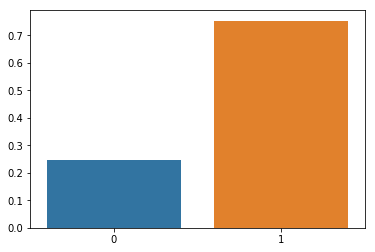

In [12]:
sns.barplot(x = lab, y = lab, estimator=lambda x: len(x)/len(lab))
plt.show()

## Modeling 

In [13]:
vocab_size = len(dict_yelp)
Adam = optimizers.Adam(lr=0.001, beta_1=0.99, beta_2=0.99, epsilon=1e-08, decay=0.01)
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

In [14]:
# units for output size in Dense layer, vocab_size for number of features in nlp in Embedding 
# tried adding dropout but it lowered accuracy, shouldn't need it if it's not overfitting
def get_model():
    model = models.Sequential()
    model.add(Embedding(len(embedding_matrix), 100, input_length=200,  embeddings_regularizer=regularizers.l2(1e-6), weights = [embedding_matrix]))
    model.add(Conv1D(100, 5))
    model.add(Conv1D(100, 3))
    model.add(MaxPooling1D(4))
    model.add(LSTM(67))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

#model = get_model()

In [15]:
def get_model2():
    model = models.Sequential()
    model.add(Embedding(len(embedding_matrix), 100, input_length=200,  embeddings_regularizer=regularizers.l2(1e-6), weights = [embedding_matrix]))
    model.add(Bidirectional(CuDNNLSTM(67, return_sequences = True)))
    model.add(Bidirectional(CuDNNLSTM(67)))
    model.add(Dense(31))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [16]:
def get_model3():
    model = models.Sequential()
    model.add(Embedding(len(embedding_matrix), 100, input_length=200,  embeddings_regularizer=regularizers.l2(.0001), weights = [embedding_matrix]))
    model.add(CuDNNLSTM(67))
    model.add(Dense(31))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['binary_crossentropy', 'accuracy'])
    model.summary()
    return model

## Training

In [17]:
model = get_model3()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          1300200   
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 67)                45292     
_________________________________________________________________
dense_1 (Dense)              (None, 31)                2108      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 32        
Total params: 1,347,632
Trainable params: 1,347,632
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.fit(train, train_y, batch_size=500, epochs=2, verbose=1, validation_split=0.2)

Train on 267212 samples, validate on 66804 samples
Epoch 1/2
267212/267212 [==============================] - 16s 61us/step - loss: 41.9354 - binary_crossentropy: 0.5574 - acc: 0.7500 - val_loss: 41.8751 - val_binary_crossentropy: 0.5415 - val_acc: 0.7534
Epoch 2/2
267212/267212 [==============================] - 15s 57us/step - loss: 41.7773 - binary_crossentropy: 0.4878 - acc: 0.7724 - val_loss: 41.6543 - val_binary_crossentropy: 0.4090 - val_acc: 0.8150


In [19]:
# # reset weights if necessary
# model.reset_states()
# adjust lr since val loss increases, seems to be going past minimum
K.set_value(model.optimizer.lr, 0.0001)


In [21]:
model.fit(train, train_y, batch_size=500, epochs=2, verbose=1, validation_split=0.2)

Train on 267212 samples, validate on 66804 samples
Epoch 1/2
267212/267212 [==============================] - 15s 57us/step - loss: 41.6345 - binary_crossentropy: 0.3945 - acc: 0.8285 - val_loss: 41.6246 - val_binary_crossentropy: 0.3889 - val_acc: 0.8319
Epoch 2/2
267212/267212 [==============================] - 16s 58us/step - loss: 41.6159 - binary_crossentropy: 0.3843 - acc: 0.8335 - val_loss: 41.6085 - val_binary_crossentropy: 0.3811 - val_acc: 0.8391


In [23]:
if re_run:
    model.save('../../data/models/lstm.hdfs')
else:
    from keras.models import load_model
    model = load_model('../../data/models/lstm.hdfs')

## Evaluation

In [25]:
from keras.models import load_model
model = load_model('../../data/models/lstm.hdfs')

In [26]:
# The loss displayed is a running average over the training epoch, 
# whereas the metric is calculated over the test set at the end of the epoch.
print(model.metrics_names)
model.evaluate(val, val_y, batch_size=500, verbose=1)

['loss', 'binary_crossentropy', 'acc']
83504/83504 [==============================] - 2s 19us/step


[0.5768013054422547, 0.4435813937751634, 0.8304392592126689]

In [27]:
def evaluate(val, val_y, regression = False):
    
        
    preds = model.predict(val)
    #idx = np.random.randint(0, len(val_y), 5000)
    pred_err = np.subtract(val_y.astype('float32'), preds.reshape(-1))
    sns.distplot(pred_err)
    plt.show()
   
    if regression:
        rmse = np.sqrt(np.mean(pred_err**2))
        print('rmse : %.4f' % rmse)
    else:
        cond_error = round((abs(pred_err) >= 0.5).sum()/len(pred_err), 4)
        binary_cross_entropy = np.mean(
                                        val_y * np.log(preds.reshape(-1)) + \
                                       (1-val_y) * np.log(1-preds.reshape(-1))
        ) 
    
        print('prob error is greater than 0.5 is %.4f' % cond_error)
        print('binary cross entropy is %.4f' % binary_cross_entropy)
    

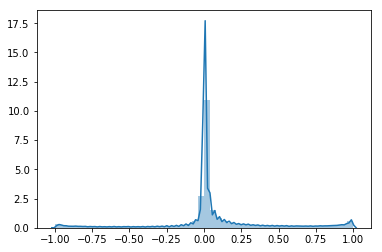

prob error is greater than 0.5 is 0.1696
binary cross entropy is -0.4436


In [28]:
evaluate(val, val_y)